# Features Engineering

My further feature engineering and EDA aim to find the patterns representing individual manner of writting specific for each of the selected 40 authors.

My hypothesis is that since these authors belong to the different generation, populational and gender groups, they are likely to have detectable style of writting and/or vocabulary, that the model will be able to identify and use for labelling the paragraphs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.tag import pos_tag
from nltk.tokenize import WordPunctTokenizer
from nltk.tag import StanfordPOSTagger

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

In [2]:
fin_lines = pd.read_csv('/Users/eiwi/GA_stuff/GA_lessons/DSI11-lessons/projects/project-capstone/For GitHub/final_lines_df_iteration_1_sent.csv')

In [3]:
fin_lines.head()

,Unnamed: 0,Unnamed: 0.1,book_author,book_line,len_line,neg,neu,pos,compound,objectivity,pos_vs_neg
0,0,0,Grant Allen,"often happens, chance stepped in at the very ...",307,0.058,0.908,0.034,-0.3400,0.908,-0.024
1,1,1,Grant Allen,"led him out to the door. policeman, in obedi...",434,0.231,0.669,0.100,-0.9233,0.669,-0.131
2,2,2,Grant Allen,"“. has nothing at all to do with the point, ...",303,0.051,0.949,0.000,-0.4588,0.949,-0.051
3,3,3,Grant Allen,"small building at the foot of the , now in co...",317,0.039,0.926,0.035,-0.0550,0.926,-0.004
4,4,4,Grant Allen,"fancy pleased him, and he talked awhile with ...",499,0.000,0.896,0.104,0.8387,0.896,0.104


# Step 1. Sentiment analysis

The sentiment analysis has been performed with Vader Tokenizer. Since it requires different kernel, this has been performed in the different notebook with the following code:

The results have been saved into a new DataFrame 'final_lines_df_iteration_1_sent.csv', which is used for the further feature engineering.

The sentiment analysis features as I assume should track author's personal level of 'gruesomeness'.
The illustration below demonstrates that there are several authors, for whom ratios between 'positive' and 'negative' words are quite different from average score.

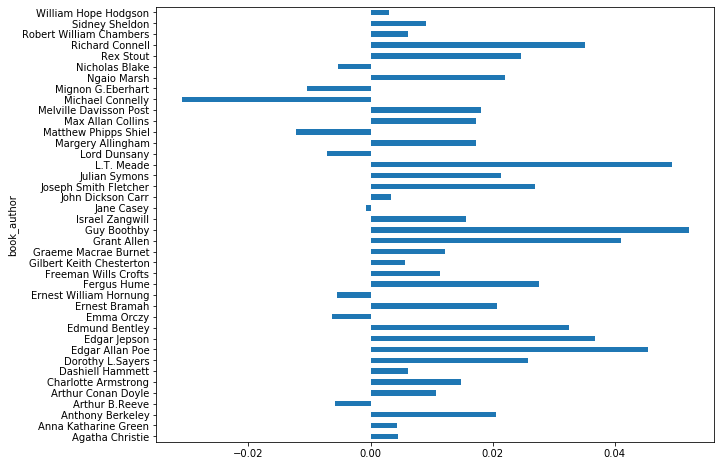

In [4]:
fin_lines.groupby('book_author')['pos_vs_neg'].mean().plot(kind = 'barh', figsize = (10,8))

# Step 2. Parts of speech tagging

In order to limit the number of features I will combine standard NLTK tags into bigger groups as follows:

*TAG MEANING*

- ADJ	adjective
- ADV	adverb	
- CONJ	conjunction	
- DET	determiner, article	
- NOUN	noun	
- NUM	numeral	
- PRT	particle	
- PRON	pronoun	
- VERB	verb	
- PUNCT punctuation marks
- other

Initially, I have been using standard NLTK pos_tag functionality, however, it had difficulties identifying the exclamation and question marks, taht in my opinion could refer to author's emotionality and potentially be an important feature, so I moved to StanfordPOSTagger. However, it still had the same issue.

In [5]:
# Adding new columns for the future features into DF

list_of_new_cols = ['ADJ','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB', 'Commas', 'Full_stops', 
                    'Dashes', 'Brackets', 'Exclamation', 'Question', 'Punct','Foreign','Other']

for new_col in list_of_new_cols:
    fin_lines.insert(len(fin_lines.columns), new_col, 0)

In [6]:
# Parts of speech (POS) tags will be added via standard NLTK WordPunctTokenizer and StanfordPOSTagger.

tok = WordPunctTokenizer()

In [7]:
# StanfordPOSTagger

jar = '/Users/eiwi/Downloads/stanford-postagger-full-2018-10-16/stanford-postagger.jar'
model = '/Users/eiwi/Downloads/stanford-postagger-full-2018-10-16/models/english-bidirectional-distsim.tagger'

st_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

In [8]:
text = fin_lines.book_line[115]
text

', very well, you shall see! I said, buttoning up my coat resolutely and rising to my feet.  shall see that I will find out everything in once. I, a stranger in , who love the oceans and the forests better than the cities, I, who know only the secrets of , behold, I will solve you this mystery of humanity.'

In [9]:
lst_words = []
lst_pos_tags = []
lst_st_tags = []

# POS tagging with pos_tag 

for i,j in pos_tag(tok.tokenize(text)):
    lst_words.append(i)
    lst_pos_tags.append(j)
    
# POS tagging with pos_tag 

for i,j in st_tagger.tag(tok.tokenize(text)):
    lst_st_tags.append(j)
    
    
compare_pos_st_df = pd.DataFrame()
compare_pos_st_df['word'] = lst_words
compare_pos_st_df['pos_tag'] = lst_pos_tags
compare_pos_st_df['stanford_tag'] = lst_st_tags

However, it still had the same issue: StanfordPOSTagger had disagreement with pos_tag, but has not identified punctuation marks correctly either.

In [10]:
compare_pos_st_df.head(15)

,word,pos_tag,stanford_tag
0,",",",",","
1,very,RB,RB
2,well,RB,RB
3,",",",",","
4,you,PRP,PRP
5,shall,MD,MD
6,see,VB,VB
7,!,.,.
8,I,PRP,PRP
9,said,VBD,VBD


In [11]:
compare_pos_st_df.tail(15)

,word,pos_tag,stanford_tag
56,the,DT,DT
57,secrets,NNS,NNS
58,of,IN,IN
59,",",",",","
60,behold,NN,RB
61,",",",",","
62,I,PRP,PRP
63,will,MD,MD
64,solve,VB,VB
65,you,PRP,PRP


Consequently, I decided to use NLTK for words' POS-tagging and calculating the whole amount of punctuation symbols in the paragraph, but also to write a custom function and determine whether the author uses certain symbols. 

In [12]:
list_of_symbols = ['RB', 'RBR', 'RBS', 'WRB', 'JJ', 'JJR', 'JJS', 'CC', 'IN', 'DT', 'PDT', 'TO', 'NN', 'NNP', 'NNPS','NNS', 
  'RP', 'WDT', 'WP', 'WP$', 'PRP', 'PRP$', 'VB','VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'EX', 'FW', 'CD',
  "$", "'", "(", "[", "{", ")", "] ", "}", ",", "-", "--", ".", "?", "!", ":", ";", "`",  "``",  "LS", "POS",
   'SYM', 'UH']
    
for line_number in range(len(fin_lines.book_line)):
    tags = dict(pos_tag(tok.tokenize(fin_lines.book_line[line_number])))
    for value in list_of_symbols:
        val_count = list(tags.values()).count(value)
        
        if value in ['RB', 'RBR', 'RBS', 'WRB']:
            fin_lines.ADV[line_number]  += val_count
            
        if value in ['JJ', 'JJR', 'JJS']:
            fin_lines.ADJ[line_number] += val_count  
           
        if value in ['CC', 'IN']:
            fin_lines.CONJ[line_number] += val_count 
        
        if value in ['DT', 'PDT', 'TO']:
            fin_lines.DET[line_number] += val_count 
            
        if value in ['NN', 'NNP', 'NNPS','NNS']:
            fin_lines.NOUN[line_number] += val_count
            
        if value in ['CD']:
            fin_lines.NUM[line_number] += val_count

        if value in ['RP']:
            fin_lines.PRT[line_number]  += val_count
 
        if value in ['WDT', 'WP', 'WP$', 'PRP', 'PRP$']:
            fin_lines.PRON[line_number] += val_count
            
        if value in ['VB','VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD', 'EX']:
            fin_lines.VERB[line_number] += val_count
            
        if value in ["$", "'", "(", "[", "{", ")", "] ", "}", ",", "-", "--", ".", "?", "!", ":", ";", "`",  "``"]:
            fin_lines.Punct[line_number]  += val_count
            
        if value in ['FW']:
            fin_lines.Foreign[line_number] += val_count
            
        if value in["LS", "POS", 'SYM', 'UH']:
            fin_lines.Other[line_number]  += val_count 

/Users/eiwi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/eiwi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/eiwi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/U

In [13]:
# Custom function

def count_punct(my_series):
    for line_number in range(len(my_series)):
        
        if '.' in my_series[line_number]:
            val_count = my_series[line_number].count(',')
            fin_lines.Full_stops[line_number]  += val_count
        
        if ',' in my_series[line_number]:
            val_count = my_series[line_number].count(',')
            fin_lines.Commas[line_number]  += val_count
            
        if ('!' in my_series[line_number]) or ('!!!' in my_series[line_number]):
            val_count = my_series[line_number].count(',')
            fin_lines.Exclamation[line_number]  += val_count
            
        if ('?' in my_series[line_number]) or ('?!' in my_series[line_number]):
            val_count = my_series[line_number].count(',')
            fin_lines.Question[line_number]  += val_count
            
        if ('(' in my_series[line_number]) and (')' in my_series[line_number]):
            val_count = my_series[line_number].count(',')
            fin_lines.Brackets[line_number]  += val_count
            
        if ('-' in my_series[line_number]) or ('--' in my_series[line_number]) or ('--' in my_series[line_number]):
            val_count = my_series[line_number].count(',')
            fin_lines.Dashes[line_number]  += val_count
            
count_punct(fin_lines.book_line)

/Users/eiwi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/eiwi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/eiwi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/eiwi/o

In [14]:
fin_lines.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)
fin_lines.reset_index(drop = True, inplace = True)

In [15]:
fin_lines.describe()

,len_line,neg,neu,pos,compound,objectivity,pos_vs_neg,ADJ,ADV,CONJ,...,VERB,Commas,Full_stops,Dashes,Brackets,Exclamation,Question,Punct,Foreign,Other
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,...,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,414.917188,0.076873,0.832306,0.090813,0.091026,0.832315,0.013940,5.515000,4.400313,8.144687,...,13.983438,5.401562,5.384688,2.196875,0.204063,0.721562,0.845938,2.989063,0.026250,0.040313
std,83.969998,0.064184,0.085503,0.064655,0.636811,0.085500,0.096382,2.644113,2.352375,2.223522,...,4.048940,2.909438,2.916974,3.371356,1.244902,2.241926,2.325568,0.957786,0.180128,0.212018
min,300.000000,0.000000,0.504000,0.000000,-0.990700,0.504000,-0.390000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,343.000000,0.029000,0.776000,0.043750,-0.541400,0.776000,-0.048000,4.000000,3.000000,7.000000,...,11.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,400.000000,0.065000,0.839000,0.080000,0.197450,0.839000,0.014000,5.000000,4.000000,8.000000,...,14.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
75%,480.000000,0.114000,0.895000,0.128000,0.700300,0.895000,0.075000,7.000000,6.000000,10.000000,...,17.000000,7.000000,7.000000,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
max,600.000000,0.443000,1.000000,0.446000,0.990900,1.000000,0.440000,21.000000,17.000000,16.000000,...,32.000000,21.000000,21.000000,21.000000,19.000000,19.000000,19.000000,7.000000,3.000000,3.000000


These features are designed to pick up author's individual style: e.g. the tendency to use more verbs or nouns, 'favourite' punctuation marks, etc.

The table below proves that some authors stand out of the common pattern (within the used sample): as we can see, Mignon G.Eberhart tends to use more adverbs than others or that Grant Allen is an absolute leader of using exclamation marks.

In [16]:
pos_author = fin_lines.groupby('book_author')['ADJ','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB', 'Commas', 'Full_stops', 
                    'Dashes', 'Brackets', 'Exclamation', 'Question', 'Punct','Foreign','Other'].mean()

/Users/eiwi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [17]:
def highlight_max(s): # highlights the maximum in a column
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [18]:
pos_author.style.apply(highlight_max)

,ADJ,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,Commas,Full_stops,Dashes,Brackets,Exclamation,Question,Punct,Foreign,Other
book_author,,,,,,,,,,,,,,,,,,
Agatha Christie,5.512500,4.825000,7.287500,3.962500,14.462500,0.425000,0.350000,5.062500,14.175000,4.675000,4.625000,1.387500,0.087500,0.850000,1.050000,2.662500,0.050000,0.062500
Anna Katharine Green,5.462500,4.062500,8.412500,4.837500,14.600000,0.337500,0.312500,6.000000,14.787500,4.975000,4.837500,1.500000,0.087500,0.837500,0.737500,2.962500,0.037500,0.025000
Anthony Berkeley,5.925000,5.387500,8.300000,4.900000,15.350000,0.525000,0.375000,4.812500,14.062500,5.175000,5.175000,1.275000,0.412500,0.275000,0.625000,2.862500,0.000000,0.050000
Arthur B.Reeve,5.050000,4.225000,7.662500,4.462500,14.087500,0.412500,0.587500,4.912500,13.775000,4.937500,4.937500,2.125000,0.112500,0.175000,0.450000,2.637500,0.025000,0.050000
Arthur Conan Doyle,5.537500,4.625000,8.687500,4.600000,15.287500,0.500000,0.550000,5.600000,14.125000,5.450000,5.450000,2.412500,0.050000,0.837500,0.887500,2.800000,0.025000,0.075000
Charlotte Armstrong,5.762500,4.625000,7.275000,4.037500,15.287500,0.375000,0.487500,5.250000,14.825000,6.000000,6.000000,1.487500,0.712500,1.412500,2.100000,2.712500,0.012500,0.025000
Dashiell Hammett,5.750000,4.062500,8.325000,4.312500,17.625000,0.625000,0.475000,4.562500,13.887500,4.862500,4.825000,2.875000,0.000000,0.512500,0.725000,3.162500,0.037500,0.087500
Dorothy L.Sayers,5.950000,4.837500,8.150000,4.075000,16.837500,0.350000,0.675000,4.950000,15.037500,6.612500,6.612500,3.575000,0.150000,0.762500,1.937500,3.050000,0.100000,0.112500
Edgar Allan Poe,6.112500,4.662500,8.375000,4.450000,16.475000,0.562500,0.262500,4.837500,12.375000,6.687500,6.525000,2.712500,1.237500,1.225000,0.600000,3.187500,0.037500,0.050000


# Step 3. Stemming and Tokens Counting

At this point I am going to reduce the number of used tokens by using Porter Stemmer and count the frequency of tehse tokens use with TfidfVectorizer.

In [19]:
porter=PorterStemmer()

In [20]:
def stemSentence(line):
    token_words=word_tokenize(line)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

stem_list = []

for line in fin_lines.book_line:
    new_line = stemSentence(line)
    stem_list.append(new_line)

In [21]:
fin_lines['book_line'] = stem_list

In [22]:
fin_lines.book_line.head()

0    often happen , chanc step in at the veri nick ...
1    led him out to the door . policeman , in obedi...
2    “ . ha noth at all to do with the point , one ...
3    small build at the foot of the , now in cours ...
4    fanci pleas him , and he talk awhil with the c...
Name: book_line, dtype: object

Next I would like to extract most representative word features, that may point out authors' "favourite" words and help to identify their writing. As suggests the following graph, this assumption seems to be realistic and worth trying.

In [23]:
# I will use CountVectorizer to illustrate the difference in frequency of using the same words by different authors

cvec = CountVectorizer(token_pattern='\w+', stop_words='english', min_df=0.003)
cvec.fit(fin_lines['book_line'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.003,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\w+', tokenizer=None,
                vocabulary=None)

In [24]:
document_matrix = cvec.transform(fin_lines['book_line'])
document_matrix

<3200x1952 sparse matrix of type '<class 'numpy.int64'>'
	with 80286 stored elements in Compressed Sparse Row format>

In [25]:
cvec_df = pd.DataFrame(document_matrix.toarray(),
                  columns=cvec.get_feature_names())

cvec_df = cvec_df.transpose().sort_values(0, ascending=False).transpose()

In [26]:
most_popular_50 = cvec_df.iloc[:, :50]
most_popular_50.insert(loc = 0, column ='book_author', value = fin_lines['book_author'])

In [27]:
most_popular_50.groupby('book_author').sum().style.apply(highlight_max)

,wa,end,son,boy,happen,wife,step,armi,examin,hi,night,veri,talk,stupid,time,pure,question,chanc,public,queer,prison,print,principl,puzzl,princess,priest,pride,quarter,price,prevent,previou,probabl,pretti,pretend,presum,press,preserv,present,presenc,quick,prepar,privat,proceed,problem,proper,prove,publish,proud,protest,protect
book_author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agatha Christie,127,5,2,3,2,5,0,0,0,46,6,15,3,0,21,0,4,1,2,0,1,2,0,0,0,0,0,2,1,1,0,2,2,0,0,1,0,1,0,0,1,0,1,0,0,2,0,0,2,0
Anna Katharine Green,96,6,0,1,0,2,5,0,2,56,9,2,5,0,9,1,8,4,1,0,2,0,1,0,0,0,1,0,0,0,0,2,1,0,1,0,0,5,2,0,3,2,3,0,0,5,0,1,0,0
Anthony Berkeley,113,0,1,0,4,2,4,0,4,76,3,12,2,0,14,0,7,8,6,0,9,1,0,0,0,0,0,2,0,0,0,5,0,1,0,1,1,3,0,1,4,0,0,0,0,3,2,0,0,0
Arthur B.Reeve,101,4,1,1,7,1,1,0,1,29,1,8,4,0,12,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,0,1,0,1,2,0,0,0,0
Arthur Conan Doyle,92,7,1,0,1,0,0,2,2,72,5,18,3,0,8,1,2,1,2,1,2,0,1,1,0,0,1,1,1,0,0,1,0,0,1,0,1,4,3,0,1,0,2,0,0,1,0,0,1,0
Charlotte Armstrong,146,4,0,3,3,3,2,0,0,54,6,7,6,1,12,1,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4,1,0,1,0,2,0,2,0,1,2,2,0,1,0,1,1,1
Dashiell Hammett,87,2,1,2,0,4,4,0,0,95,10,3,3,0,17,0,0,2,0,0,0,2,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,3,0,1,0,0,1,0,3,0,0,1
Dorothy L.Sayers,91,2,2,3,5,3,0,0,0,66,9,12,1,0,16,0,5,0,0,1,3,2,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,4,0,4,1,1,0,0,0,4,0,0,0
Edgar Allan Poe,69,2,0,1,0,4,3,1,0,47,2,15,1,0,4,0,3,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,6,1,0,1,0,2,0,1,3,3,1,0,1


The following graph shows that the authios use the same 20 most popular words differently: Nililas Blake and Matthew Phipps Shiel use the word 'night' more seldom than others, while Agatha Christie and Ernest Bramah mention 'time' a lot, Grant Allen (who has already been identified as a frequent user of exclamation marks) also uses word token 'very', and so on. 

However, this representation is based only on the word frequency, while the better approach would be to consider the number of the paragraphs containing these words too (TfIdf approach). This will allow not only to identify the frequently used words, but also evaluate how important a word is to a paragraph in a collection or corpus. Therefore, I will use TfidfVectorizer for the further feature engineering.

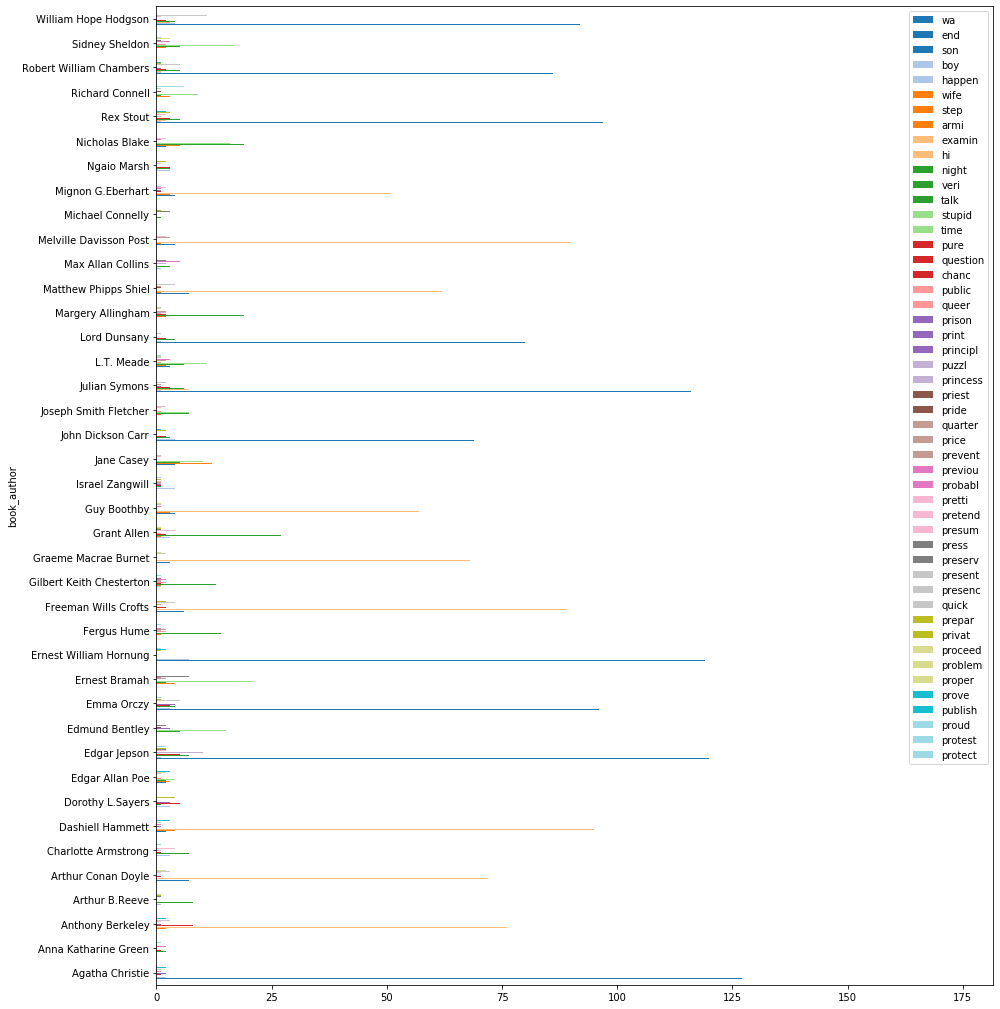

In [28]:
most_popular_50.groupby('book_author').sum().plot(kind = 'barh', figsize = (15,18), colormap = 'tab20')

In [29]:
# Counting

tvec = TfidfVectorizer(stop_words='english',  encoding='utf-8', 
                       lowercase=True, analyzer='word', 
                       ngram_range=(1, 3), min_df=0.003) # I only take 3% of all corpus to make the computations easier

In [30]:
tvec.fit(fin_lines['book_line'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0.003, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [31]:
import numpy as np 

tdidf_df = pd.DataFrame(np.round(tvec.transform(fin_lines['book_line']).toarray(),3), 
                        columns = tvec.get_feature_names())

This gives me 190119 predictors representing n-grams of the level 1 to 3, most frequently used in the chosen paragraphs.

In [32]:
new_df = pd.concat([fin_lines, tdidf_df], join="outer", axis = 1)

In [33]:
new_df.to_csv(r'/Users/eiwi/GA_stuff/GA_lessons/DSI11-lessons/projects/project-capstone/For GitHub/df_40_authors_all_features_0003percent.csv', columns = new_df.columns)